In [1]:
import shap
import numpy as np
import xgboost as xgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pickle


/Users/bkuwahara/Documents/GitHub/shap/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the diabetes dataset
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 3351.001637862091


In [10]:
feature_names = diabetes.feature_names
M = len(feature_names)
age = shap.ChainComponent.from_set({0}, M, True, "Demographics")
sex = shap.ChainComponent.from_set({1}, M, True, "Demographics")
vitals = shap.ChainComponent.from_set({2,3}, M, True, "Vitals")
blood = shap.ChainComponent.from_set(set(range(4,len(feature_names))), M, False, "Blood Tests")

In [11]:
f = lambda x: model.predict(x)
single_sex = X_test[X_test[:,1] > 0,:]
preds = model.predict(X_test)
causal_explainer = shap.GraphKernelExplainer(f, single_sex, [age, sex, vitals, blood], [[vitals, blood]], feature_names=feature_names)
baseline_explainer = shap.KernelExplainer(f, single_sex, feature_names=feature_names)


In [12]:
import cProfile
# cProfile.run('causal_explanation = causal_explainer(single_sex[:10], samples_per_subset=41)')
causal_explanation = causal_explainer(single_sex, samples_per_subset=41)


100%|██████████| 41/41 [02:40<00:00,  3.92s/it]

         271472966 function calls (271469302 primitive calls) in 160.596 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    41902    0.079    0.000  157.962    0.004 /Users/bkuwahara/Documents/GitHub/shap/shap/explainers/_graph_kernel.py:506(addsample)
    41902   19.983    0.000  157.743    0.004 /Users/bkuwahara/Documents/GitHub/shap/shap/utils/_graph.py:147(interventional_distribution)
       41    0.063    0.002  156.854    3.826 /Users/bkuwahara/Documents/GitHub/shap/shap/explainers/_graph_kernel.py:284(explain)
        1    0.000    0.000  144.690  144.690 /Users/bkuwahara/Documents/GitHub/shap/shap/explainers/_graph_kernel.py:178(shap_values)
  1692767   12.986    0.000   62.270    0.000 {method 'multivariate_normal' of 'numpy.random.mtrand.RandomState' objects}
  1692767   18.081    0.000   38.778    0.000 /Users/bkuwahara/Documents/GitHub/shap/shap/utils/_graph.py:207(conditional_distribution)
  1692767    1.550

In [6]:
baseline_explanation = baseline_explainer(single_sex)

  0%|          | 0/41 [00:00<?, ?it/s]

100%|██████████| 41/41 [00:01<00:00, 25.25it/s]

         1120457 function calls (1118054 primitive calls) in 1.627 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       41    0.025    0.001    1.489    0.036 /Users/bkuwahara/Documents/GitHub/shap/shap/explainers/_kernel.py:309(explain)
       41    0.979    0.024    1.170    0.029 /Users/bkuwahara/Documents/GitHub/shap/shap/explainers/_kernel.py:619(run)
    16810    0.012    0.000    0.276    0.000 /Users/bkuwahara/Documents/GitHub/shap/shap/explainers/_kernel.py:505(not_equal)
       41    0.005    0.000    0.263    0.006 /Users/bkuwahara/Documents/GitHub/shap/shap/explainers/_kernel.py:513(varying_groups)
    16810    0.046    0.000    0.260    0.000 /Users/bkuwahara/Documents/GitHub/shap/venv/lib/python3.12/site-packages/numpy/core/numeric.py:2249(isclose)
       82    0.000    0.000    0.197    0.002 /var/folders/38/22n1fwlx0h9_678vykb1gyyh0000gn/T/ipykernel_86978/1137632139.py:1(<lambda>)
       82    0.000    0

In [11]:
for explanation in [baseline_explanation, causal_explanation]:
    print(np.abs(explanation.values.sum(axis=1) + explanation.base_values - preds).min()) # these should be close to zero

ValueError: operands could not be broadcast together with shapes (41,) (89,) 

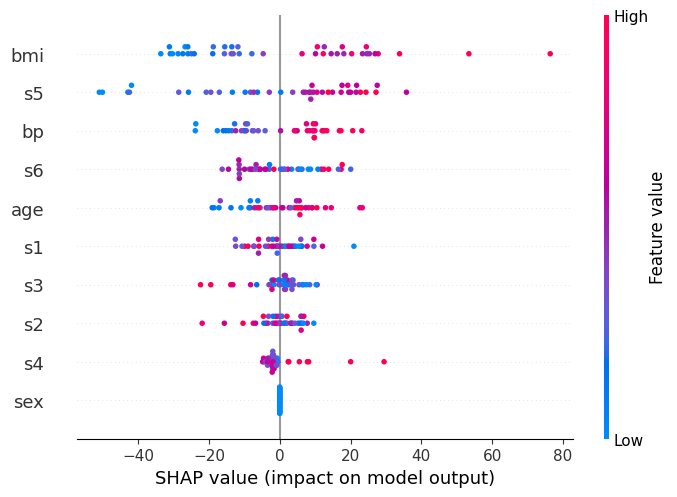

In [13]:
shap.plots.beeswarm(baseline_explanation)

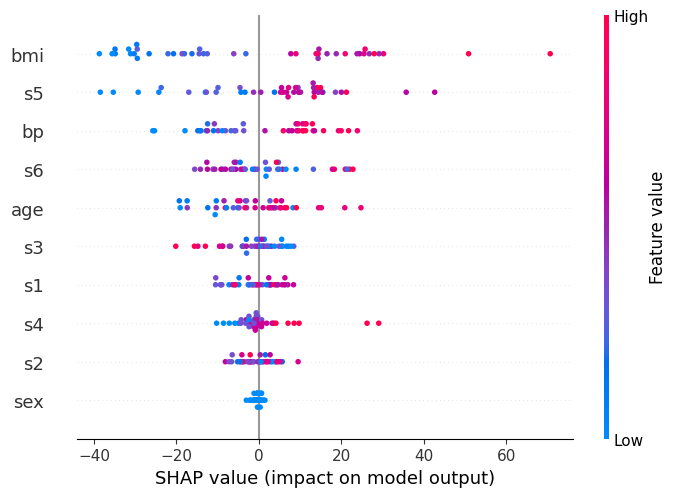

In [14]:
shap.plots.beeswarm(causal_explanation)

In [5]:
e1 = shap.GraphKernelExplainer(f, samples, [c1, c2, c3], [[c1, c2], [c2, c3], [c1,c3]], feature_names=feature_names)
e2 = shap.GraphKernelExplainer(f, samples, [c1, c2, c3], [[c2, c3]], feature_names=feature_names)
e3 = shap.GraphKernelExplainer(f, samples, [c1, c2, c3], [[c2, c1], [c3, c2]], feature_names=feature_names)

In [6]:
explanations = []
for e in [e1, e2, e3]:
    exp = e(X_test[0:20,:], samples_per_subset=25)
    explanations.append(exp)

100%|██████████| 20/20 [00:53<00:00,  2.67s/it]


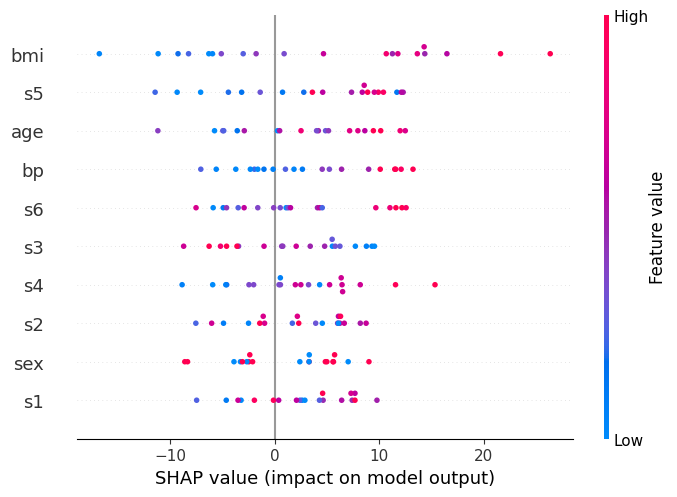

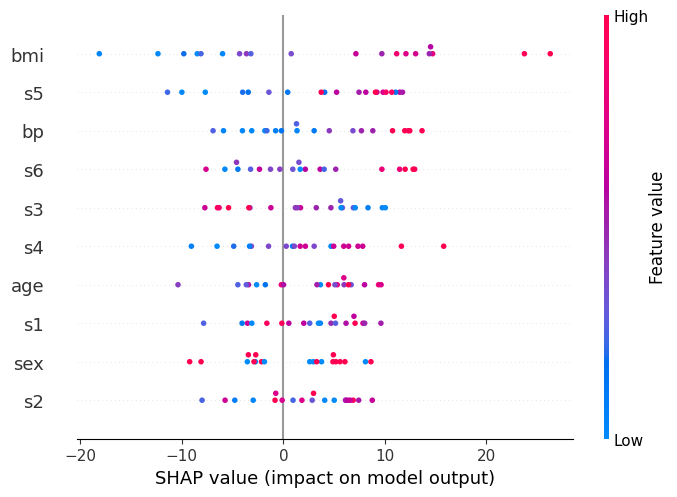

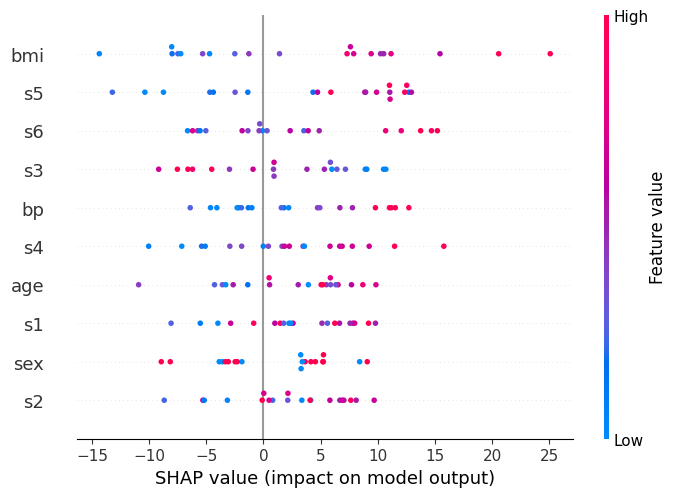

In [7]:
for e in explanations:
    shap.plots.beeswarm(e)

In [16]:
for e in explanations:
    rankings = np.argsort(np.abs(e.values).mean(axis=0))[::-1]
    sorted_feature_names = [feature_names[i] for i in rankings]
    print(sorted_feature_names)

['bmi', 's5', 'age', 'bp', 's6', 's3', 's4', 's2', 'sex', 's1']
['bmi', 's5', 'bp', 's6', 's3', 's4', 'age', 's1', 'sex', 's2']
['bmi', 's5', 's6', 's3', 'bp', 's4', 'age', 's1', 'sex', 's2']


In [18]:
for e in explanations:
    print(np.abs(e.values[:,0]).mean())

6.129160498290775
5.020508532188421
5.033358867957849


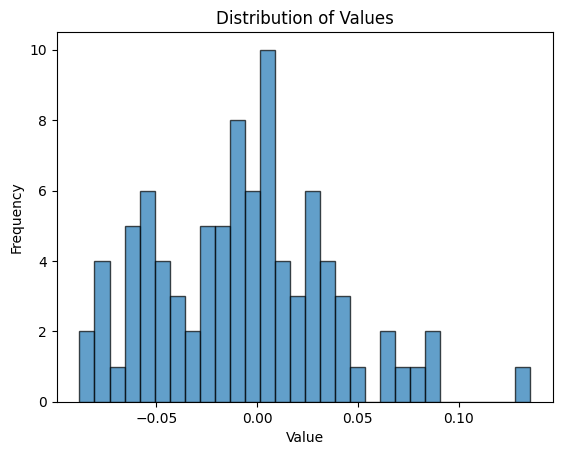

In [13]:

# Create a NumPy array with random values

# Plot the histogram
plt.hist(X_test[:,9], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()
